# Homework 3 - Task 3 -  Mountain Car Environment

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [1]:
# !apt update
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install piglet

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

## Replay memory

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

## Network definition

In [3]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 400),
                nn.Tanh(),
                nn.Linear(400, 300),
                nn.Tanh(),
                nn.Linear(300, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

## Exploration Policy

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [6]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

In [7]:
def set_exploration_profile(initial_value, num_iterations, step, mode):
    
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * step) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(int(num_iterations))]

    if mode=='softmax':
        plt.figure(figsize=(12,8))
        plt.plot(exploration_profile)
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Exploration profile (Softmax temperature)')
        return exploration_profile
    else:
        exploration_profile_eps = [i/(initial_value*1.0) for i in exploration_profile]
        plt.figure(figsize=(12,8))
        plt.plot(exploration_profile_eps)
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Exploration profile (Softmax temperature)')
        return exploration_profile_eps

# Gym Environment (CartPole-v1)

In [8]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


## Update function

In [9]:
## Update function

def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

# Network update

In [73]:
# Network update

## Initialization

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

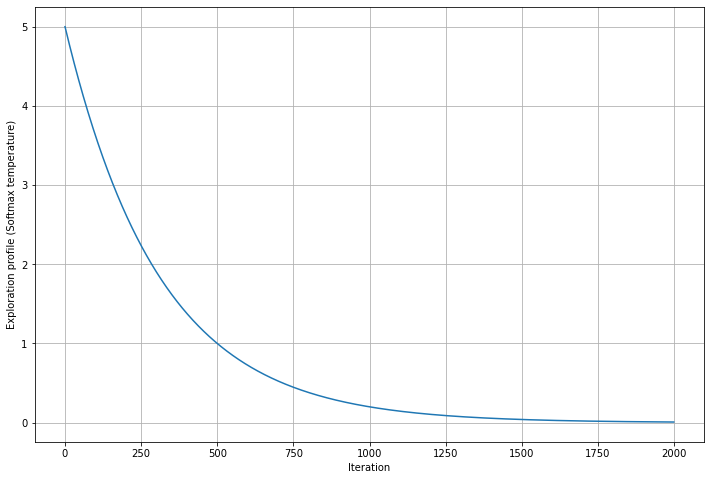

In [75]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

# set exploration profile
exp_mode = 'softmax'
exploration_profile = set_exploration_profile(5, 2000, 4, exp_mode)

## Training loop

In [76]:
## Training loop
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

score_log = []
max_pos_log = []
pos_weight = 0.5
vel_weight = 1

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    num_episodes = 0
    done = False

    max_pos = -1.2
    # Go on until the pole falls off
    while not done:

      if exp_mode == 'softmax':      
          # Choose the action following the policy
          action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

      else:
        action, q_values = choose_action_epsilon_greedy(policy_net, state, tau)
       
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      if state[0]>max_pos:
        max_pos = state[0]

      reward = max_pos
      score = score + reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      else:
          num_episodes +=1

      # Update the replay memory if score i not the worst
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    # add to the score log
    max_pos_log.append(max_pos)
    score_log.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {max_pos} - Temperature: {tau} - Time: {num_episodes} - Score: {score}") # Print the final score

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -0.4046362497819583 - Temperature: 5.0 - Time: 199 - Score: -80.92724995639172
EPISODE: 2 - FINAL SCORE: -0.39199983874743116 - Temperature: 4.983931496009206 - Time: 199 - Score: -94.29616464221951
EPISODE: 3 - FINAL SCORE: -0.414366076514631 - Temperature: 4.967914631382513 - Time: 199 - Score: -89.03138320677922
EPISODE: 4 - FINAL SCORE: -0.41245148723088054 - Temperature: 4.951949240166455 - Time: 199 - Score: -87.08991276008497
EPISODE: 5 - FINAL SCORE: -0.3779189634695353 - Temperature: 4.93603515694089 - Time: 199 - Score: -79.57165656075662
EPISODE: 6 - FINAL SCORE: -0.3736099427212954 - Temperature: 4.9201722168172894 - Time: 199 - Score: -93.77905697963715
EPISODE: 7 - FINAL SCORE: -0.319479603677558 - Temperature: 4.904360255437025 - Time: 199 - Score: -75.30944011352302
EPISODE: 8 - FINAL SCORE: -0.31354871316778976 - Temperature: 4.888599108969669 - Time: 199 - Score: -82.91836521865812
EPISODE: 9 - FINAL SCORE: -0.40971

EPISODE: 68 - FINAL SCORE: -0.3857861992589354 - Temperature: 4.030027630618372 - Time: 199 - Score: -87.6105027382279
EPISODE: 69 - FINAL SCORE: -0.43990194653993203 - Temperature: 4.017076327605253 - Time: 199 - Score: -91.37274067623467
EPISODE: 70 - FINAL SCORE: -0.31429074810145097 - Temperature: 4.004166646204963 - Time: 199 - Score: -87.22907604104935
Updating target network...
EPISODE: 71 - FINAL SCORE: -0.43891766301549506 - Temperature: 3.9912984526580937 - Time: 199 - Score: -87.78353260309939
EPISODE: 72 - FINAL SCORE: -0.3925851316142277 - Temperature: 3.9784716136350964 - Time: 199 - Score: -94.18364090517204
EPISODE: 73 - FINAL SCORE: -0.42047998676000764 - Temperature: 3.965685996234905 - Time: 199 - Score: -89.84646074800085
EPISODE: 74 - FINAL SCORE: -0.3847262268927575 - Temperature: 3.9529414679835586 - Time: 199 - Score: -89.62376706472914
EPISODE: 75 - FINAL SCORE: -0.30551171796882287 - Temperature: 3.9402378968328247 - Time: 199 - Score: -83.964843083959
EPISODE

EPISODE: 135 - FINAL SCORE: -0.39428575645837965 - Temperature: 3.248224540709507 - Time: 199 - Score: -85.56925807201415
EPISODE: 136 - FINAL SCORE: -0.3278232496238881 - Temperature: 3.2377857189104295 - Time: 199 - Score: -80.97934192758592
EPISODE: 137 - FINAL SCORE: -0.4728396836412985 - Temperature: 3.2273804443613003 - Time: 199 - Score: -99.21611861781047
EPISODE: 138 - FINAL SCORE: -0.41743457678803453 - Temperature: 3.2170086092512946 - Time: 199 - Score: -91.65153758001797
EPISODE: 139 - FINAL SCORE: -0.4339998937273047 - Temperature: 3.2066701061160603 - Time: 199 - Score: -92.01862225655854
EPISODE: 140 - FINAL SCORE: -0.18672406455924803 - Temperature: 3.196364827836603 - Time: 199 - Score: -55.92879015960475
Updating target network...
EPISODE: 141 - FINAL SCORE: -0.4273867492528284 - Temperature: 3.186092667638178 - Time: 199 - Score: -86.45152073410948
EPISODE: 142 - FINAL SCORE: -0.3406101782720011 - Temperature: 3.175853519089182 - Time: 199 - Score: -82.2182112072674

Updating target network...
EPISODE: 201 - FINAL SCORE: -0.322191144248383 - Temperature: 2.6265278044037954 - Time: 199 - Score: -69.8364716202439
EPISODE: 202 - FINAL SCORE: -0.32768401936551106 - Temperature: 2.6180869299023968 - Time: 199 - Score: -82.62440971030337
EPISODE: 203 - FINAL SCORE: -0.41515545194018905 - Temperature: 2.6096731818461203 - Time: 199 - Score: -84.35078330947998
EPISODE: 204 - FINAL SCORE: -0.41654579302561406 - Temperature: 2.601286473058688 - Time: 199 - Score: -85.85085862497593
EPISODE: 205 - FINAL SCORE: -0.40665180635905174 - Temperature: 2.59292671664398 - Time: 199 - Score: -87.48198969921235
EPISODE: 206 - FINAL SCORE: -0.4330277461077132 - Temperature: 2.5845938259851344 - Time: 199 - Score: -93.53434151826279
EPISODE: 207 - FINAL SCORE: -0.38020363510566285 - Temperature: 2.57628771474365 - Time: 199 - Score: -80.80322539155725
EPISODE: 208 - FINAL SCORE: -0.331848431346925 - Temperature: 2.568008296858491 - Time: 199 - Score: -75.75704181753258
E

EPISODE: 267 - FINAL SCORE: -0.2606287315870042 - Temperature: 2.1238212509161567 - Time: 199 - Score: -67.93733199273257
EPISODE: 268 - FINAL SCORE: -0.4188807181593355 - Temperature: 2.116995924866941 - Time: 199 - Score: -98.12038853975432
EPISODE: 269 - FINAL SCORE: -0.37661597671197855 - Temperature: 2.110192533373497 - Time: 199 - Score: -78.30832484994032
EPISODE: 270 - FINAL SCORE: -0.41081516815703945 - Temperature: 2.103411005944726 - Time: 199 - Score: -87.79249304023375
Updating target network...
EPISODE: 271 - FINAL SCORE: -0.4393906831224769 - Temperature: 2.0966512723160657 - Time: 199 - Score: -90.88352655965303
EPISODE: 272 - FINAL SCORE: -0.1878203367446439 - Temperature: 2.0899132624487633 - Time: 199 - Score: -58.40942420168037
EPISODE: 273 - FINAL SCORE: -0.38726313041311805 - Temperature: 2.0831969065291487 - Time: 199 - Score: -90.87965238196475
EPISODE: 274 - FINAL SCORE: -0.42894584248527057 - Temperature: 2.0765021349679142 - Time: 199 - Score: -91.42402377507

EPISODE: 333 - FINAL SCORE: -0.39718415402515794 - Temperature: 1.7173306516231412 - Time: 199 - Score: -90.86996298194238
EPISODE: 334 - FINAL SCORE: -0.3666793846552386 - Temperature: 1.7118116647373174 - Time: 199 - Score: -78.88649111472911
EPISODE: 335 - FINAL SCORE: -0.4154402853408767 - Temperature: 1.7063104142240537 - Time: 199 - Score: -91.05688824124348
EPISODE: 336 - FINAL SCORE: -0.363965427154857 - Temperature: 1.7008268430839553 - Time: 199 - Score: -89.06832841201432
EPISODE: 337 - FINAL SCORE: -0.2896410697997441 - Temperature: 1.6953608945008063 - Time: 199 - Score: -80.93208004343931
EPISODE: 338 - FINAL SCORE: -0.40559595829873946 - Temperature: 1.6899125118409821 - Time: 199 - Score: -81.13323009301985
EPISODE: 339 - FINAL SCORE: -0.3478909362841264 - Temperature: 1.6844816386528603 - Time: 199 - Score: -87.25835463700139
EPISODE: 340 - FINAL SCORE: -0.40967598198529076 - Temperature: 1.6790682186662378 - Time: 199 - Score: -81.93535966655966
Updating target networ

EPISODE: 399 - FINAL SCORE: -0.35306513788119925 - Temperature: 1.388640671022644 - Time: 199 - Score: -78.78655619485014
EPISODE: 400 - FINAL SCORE: -0.35226893343433047 - Temperature: 1.3841779953898228 - Time: 199 - Score: -88.40992523932647
Updating target network...
EPISODE: 401 - FINAL SCORE: -0.45531663135804645 - Temperature: 1.3797296614612446 - Time: 199 - Score: -97.4046268383589
EPISODE: 402 - FINAL SCORE: -0.29337014822486646 - Temperature: 1.3752956231469635 - Time: 199 - Score: -70.8005033330861
EPISODE: 403 - FINAL SCORE: -0.4618994648587549 - Temperature: 1.3708758345051517 - Time: 199 - Score: -95.57633570369445
EPISODE: 404 - FINAL SCORE: -0.38027817605214664 - Temperature: 1.366470249741626 - Time: 199 - Score: -91.91362260035903
EPISODE: 405 - FINAL SCORE: -0.26249138049637494 - Temperature: 1.3620788232093712 - Time: 199 - Score: -82.32196063884308
EPISODE: 406 - FINAL SCORE: -0.45020938940398025 - Temperature: 1.357701509408068 - Time: 199 - Score: -94.7857327275

EPISODE: 465 - FINAL SCORE: -0.2583210840522935 - Temperature: 1.1228605926270852 - Time: 199 - Score: -83.07774528218425
EPISODE: 466 - FINAL SCORE: -0.358853311408818 - Temperature: 1.1192520546443385 - Time: 199 - Score: -74.62073444190878
EPISODE: 467 - FINAL SCORE: -0.4656389048800151 - Temperature: 1.1156551134229873 - Time: 199 - Score: -98.37435961703471
EPISODE: 468 - FINAL SCORE: -0.4298024101152552 - Temperature: 1.1120697316945098 - Time: 199 - Score: -92.49988541844817
EPISODE: 469 - FINAL SCORE: -0.3513874882259763 - Temperature: 1.108495872310155 - Time: 199 - Score: -85.93743295235906
EPISODE: 470 - FINAL SCORE: -0.4568667210910313 - Temperature: 1.1049334982405563 - Time: 199 - Score: -94.56364179495421
Updating target network...
EPISODE: 471 - FINAL SCORE: -0.4133299613003178 - Temperature: 1.101382572575348 - Time: 199 - Score: -82.66618158853872
EPISODE: 472 - FINAL SCORE: -0.408395154346324 - Temperature: 1.0978430585227847 - Time: 199 - Score: -87.35644745796307
E

Updating target network...
EPISODE: 531 - FINAL SCORE: -0.3425561938927779 - Temperature: 0.907949721468506 - Time: 199 - Score: -74.4603929940225
EPISODE: 532 - FINAL SCORE: -0.37453839108525266 - Temperature: 0.9050318427239347 - Time: 199 - Score: -83.71093984564325
EPISODE: 533 - FINAL SCORE: -0.3768621611680783 - Temperature: 0.9021233411686137 - Time: 199 - Score: -86.8474214713405
EPISODE: 534 - FINAL SCORE: -0.43028729339217914 - Temperature: 0.8992241866670625 - Time: 199 - Score: -86.19516696366914
EPISODE: 535 - FINAL SCORE: -0.45429176608662414 - Temperature: 0.8963343491806469 - Time: 199 - Score: -93.4603318378501
EPISODE: 536 - FINAL SCORE: -0.29164690540031674 - Temperature: 0.893453798767268 - Time: 199 - Score: -72.59838337160622
EPISODE: 537 - FINAL SCORE: -0.3867627055323135 - Temperature: 0.8905825055810517 - Time: 199 - Score: -87.9885824323135
EPISODE: 538 - FINAL SCORE: -0.3817006257630055 - Temperature: 0.8877204398720396 - Time: 199 - Score: -88.49651840615682

EPISODE: 597 - FINAL SCORE: -0.4112942571864065 - Temperature: 0.7341719017727799 - Time: 199 - Score: -94.71486323186225
EPISODE: 598 - FINAL SCORE: -0.3792515169197317 - Temperature: 0.731812492946067 - Time: 199 - Score: -81.18525241191554
EPISODE: 599 - FINAL SCORE: -0.47236930947676015 - Temperature: 0.7294606665533837 - Time: 199 - Score: -96.0012056784938
EPISODE: 600 - FINAL SCORE: -0.4036754438115809 - Temperature: 0.7271163982270556 - Time: 199 - Score: -84.52629640574052
Updating target network...
EPISODE: 601 - FINAL SCORE: -0.3548920150120402 - Temperature: 0.7247796636777191 - Time: 199 - Score: -74.23891297598051
EPISODE: 602 - FINAL SCORE: -0.3708198059238691 - Temperature: 0.7224504386940688 - Time: 199 - Score: -80.21099190097517
EPISODE: 603 - FINAL SCORE: -0.44488854982396137 - Temperature: 0.7201286991426075 - Time: 199 - Score: -91.93340957599587
EPISODE: 604 - FINAL SCORE: -0.45503985216621173 - Temperature: 0.7178144209673959 - Time: 199 - Score: -94.78631515169

EPISODE: 663 - FINAL SCORE: -0.41946447072842635 - Temperature: 0.5936544376938353 - Time: 199 - Score: -88.05988027337693
EPISODE: 664 - FINAL SCORE: -0.4220492766479936 - Temperature: 0.5917466099535882 - Time: 199 - Score: -84.40985532959903
EPISODE: 665 - FINAL SCORE: -0.4268831874464836 - Temperature: 0.5898449134008725 - Time: 199 - Score: -89.55111037804608
EPISODE: 666 - FINAL SCORE: -0.31815174947037067 - Temperature: 0.5879493283318863 - Time: 199 - Score: -69.04270370080062
EPISODE: 667 - FINAL SCORE: -0.426596797630097 - Temperature: 0.5860598351061492 - Time: 199 - Score: -86.66796378205177
EPISODE: 668 - FINAL SCORE: -0.3429898003299456 - Temperature: 0.5841764141462998 - Time: 199 - Score: -79.833905043169
EPISODE: 669 - FINAL SCORE: -0.3710349519143279 - Temperature: 0.5822990459378923 - Time: 199 - Score: -81.64131593012374
EPISODE: 670 - FINAL SCORE: -0.39653306880385103 - Temperature: 0.5804277110291947 - Time: 199 - Score: -83.33187160814963
Updating target network.

EPISODE: 729 - FINAL SCORE: -0.40911667931123913 - Temperature: 0.48003143479421334 - Time: 199 - Score: -84.15342827474728
EPISODE: 730 - FINAL SCORE: -0.35204619410082055 - Temperature: 0.47848875738907387 - Time: 199 - Score: -81.91779231761377
Updating target network...
EPISODE: 731 - FINAL SCORE: -0.45553098840726136 - Temperature: 0.47695103768754266 - Time: 199 - Score: -96.07590848249063
EPISODE: 732 - FINAL SCORE: -0.3959658194538658 - Temperature: 0.47541825975704355 - Time: 199 - Score: -84.97772141980207
EPISODE: 733 - FINAL SCORE: -0.4508169140749609 - Temperature: 0.4738904077162031 - Time: 199 - Score: -91.04502926375953
EPISODE: 734 - FINAL SCORE: -0.44580089851793997 - Temperature: 0.47236746573468574 - Time: 199 - Score: -94.99659929735155
EPISODE: 735 - FINAL SCORE: -0.43228249546501124 - Temperature: 0.47084941803302993 - Time: 199 - Score: -86.45649909300245
EPISODE: 736 - FINAL SCORE: -0.4484655002239439 - Temperature: 0.4693362488824846 - Time: 199 - Score: -96.0

EPISODE: 795 - FINAL SCORE: -0.3945363322453513 - Temperature: 0.3881554044904328 - Time: 199 - Score: -94.95453498160447
EPISODE: 796 - FINAL SCORE: -0.4200312132911668 - Temperature: 0.38690798915721225 - Time: 199 - Score: -90.35158663989091
EPISODE: 797 - FINAL SCORE: -0.4106210841944319 - Temperature: 0.3856645826436438 - Time: 199 - Score: -82.12421683888637
EPISODE: 798 - FINAL SCORE: -0.3658147355856384 - Temperature: 0.38442517206658033 - Time: 199 - Score: -81.63835395189764
EPISODE: 799 - FINAL SCORE: -0.387927616780215 - Temperature: 0.38318974458427757 - Time: 199 - Score: -89.84147493036423
EPISODE: 800 - FINAL SCORE: -0.413123642314832 - Temperature: 0.3819582873962609 - Time: 199 - Score: -94.76218999233521
Updating target network...
EPISODE: 801 - FINAL SCORE: -0.34502236973420075 - Temperature: 0.38073078774319213 - Time: 199 - Score: -93.6736183313301
EPISODE: 802 - FINAL SCORE: -0.28340488228211563 - Temperature: 0.37950723290673827 - Time: 199 - Score: -84.45098979

Updating target network...
EPISODE: 861 - FINAL SCORE: -0.23272771813492849 - Temperature: 0.3138640662141648 - Time: 199 - Score: -73.47986758067054
EPISODE: 862 - FINAL SCORE: -0.4168264589274167 - Temperature: 0.31285540101405895 - Time: 199 - Score: -87.79803337397334
EPISODE: 863 - FINAL SCORE: -0.35274059592685536 - Temperature: 0.31184997736211184 - Time: 199 - Score: -76.771104589975
EPISODE: 864 - FINAL SCORE: -0.31084750848395015 - Temperature: 0.31084778484095743 - Time: 199 - Score: -77.37909898987257
EPISODE: 865 - FINAL SCORE: -0.36617684585704474 - Temperature: 0.30984881306670814 - Time: 199 - Score: -88.92140972982443
EPISODE: 866 - FINAL SCORE: -0.38226899334391 - Temperature: 0.30885305168884714 - Time: 199 - Score: -84.35632508252985
EPISODE: 867 - FINAL SCORE: -0.353136847891305 - Temperature: 0.3078604903901209 - Time: 199 - Score: -79.84191390663486
EPISODE: 868 - FINAL SCORE: -0.3136859342062116 - Temperature: 0.30687111888643265 - Time: 199 - Score: -75.3681588

EPISODE: 927 - FINAL SCORE: -0.4259987214040175 - Temperature: 0.2537917826748119 - Time: 199 - Score: -91.39483525363221
EPISODE: 928 - FINAL SCORE: -0.33614739327517484 - Temperature: 0.2529761718202637 - Time: 199 - Score: -80.28000554886465
EPISODE: 929 - FINAL SCORE: -0.38093188196777167 - Temperature: 0.2521631820949698 - Time: 199 - Score: -87.44004084627235
EPISODE: 930 - FINAL SCORE: -0.3779937631225826 - Temperature: 0.2513528050754049 - Time: 199 - Score: -88.00655070045873
Updating target network...
EPISODE: 931 - FINAL SCORE: -0.35283508188145596 - Temperature: 0.25054503236511466 - Time: 199 - Score: -75.4240903260432
EPISODE: 932 - FINAL SCORE: -0.41408209727420847 - Temperature: 0.24973985559462816 - Time: 199 - Score: -88.80468126499832
EPISODE: 933 - FINAL SCORE: -0.2966636151945308 - Temperature: 0.24893726642137168 - Time: 199 - Score: -88.46916313725512
EPISODE: 934 - FINAL SCORE: -0.4031764384339126 - Temperature: 0.24813725652958185 - Time: 199 - Score: -86.39555

EPISODE: 993 - FINAL SCORE: -0.35957707696862545 - Temperature: 0.2052170856325702 - Time: 199 - Score: -85.65921375393091
EPISODE: 994 - FINAL SCORE: -0.31810439875564617 - Temperature: 0.20455757932067703 - Time: 199 - Score: -82.40092008739632
EPISODE: 995 - FINAL SCORE: -0.34471310618653894 - Temperature: 0.20390019246474475 - Time: 199 - Score: -79.61483698841796
EPISODE: 996 - FINAL SCORE: -0.3293799969769528 - Temperature: 0.20324491825347607 - Time: 199 - Score: -87.46397334794817
EPISODE: 997 - FINAL SCORE: -0.36363041702795673 - Temperature: 0.20259174989746315 - Time: 199 - Score: -90.76237144820021
EPISODE: 998 - FINAL SCORE: -0.42041141722528796 - Temperature: 0.2019406806291173 - Time: 199 - Score: -91.63326965980428
EPISODE: 999 - FINAL SCORE: -0.4198757367693777 - Temperature: 0.2012917037025988 - Time: 199 - Score: -97.27354328860186
EPISODE: 1000 - FINAL SCORE: -0.3579974111668059 - Temperature: 0.20064481239374704 - Time: 199 - Score: -90.42968633024793
Updating targ

EPISODE: 1058 - FINAL SCORE: -0.42067348822568723 - Temperature: 0.16647438346662605 - Time: 199 - Score: -93.2602805140419
EPISODE: 1059 - FINAL SCORE: -0.27189726364077 - Temperature: 0.16593938460760638 - Time: 199 - Score: -80.36880675693052
EPISODE: 1060 - FINAL SCORE: -0.3253217602411925 - Temperature: 0.16540610507484693 - Time: 199 - Score: -81.1811408035238
Updating target network...
EPISODE: 1061 - FINAL SCORE: -0.28353947941771884 - Temperature: 0.16487453934294755 - Time: 199 - Score: -78.66344575926563
EPISODE: 1062 - FINAL SCORE: -0.37718561889419033 - Temperature: 0.1643446819042651 - Time: 199 - Score: -84.4596364102703
EPISODE: 1063 - FINAL SCORE: -0.3394716670804131 - Temperature: 0.16381652726885618 - Time: 199 - Score: -73.83795704375264
EPISODE: 1064 - FINAL SCORE: -0.4057318401765217 - Temperature: 0.1632900699644207 - Time: 199 - Score: -81.14636803530462
EPISODE: 1065 - FINAL SCORE: -0.4531717125565007 - Temperature: 0.1627653045362446 - Time: 199 - Score: -93.0

EPISODE: 1123 - FINAL SCORE: -0.3230534317996771 - Temperature: 0.13504587235106305 - Time: 199 - Score: -82.04268007354595
EPISODE: 1124 - FINAL SCORE: -0.3246321340233584 - Temperature: 0.1346118753233004 - Time: 199 - Score: -81.65503248338271
EPISODE: 1125 - FINAL SCORE: -0.3441143136499923 - Temperature: 0.13417927303213226 - Time: 199 - Score: -90.67445207140494
EPISODE: 1126 - FINAL SCORE: -0.4739155173458111 - Temperature: 0.13374806099529254 - Time: 199 - Score: -96.10637811655049
EPISODE: 1127 - FINAL SCORE: -0.3465166384322116 - Temperature: 0.13331823474491977 - Time: 199 - Score: -74.02800853921833
EPISODE: 1128 - FINAL SCORE: -0.32431909991919766 - Temperature: 0.13288978982751093 - Time: 199 - Score: -85.98972260389674
EPISODE: 1129 - FINAL SCORE: -0.4220702429663675 - Temperature: 0.1324627218038751 - Time: 199 - Score: -84.4140485932738
EPISODE: 1130 - FINAL SCORE: -0.44410776902042315 - Temperature: 0.1320370262490877 - Time: 199 - Score: -97.59650039747832
Updating t

EPISODE: 1188 - FINAL SCORE: -0.36955246320682894 - Temperature: 0.10955071440595399 - Time: 199 - Score: -78.05988182738746
EPISODE: 1189 - FINAL SCORE: -0.3484729237281465 - Temperature: 0.1091986511876287 - Time: 199 - Score: -84.3374201111052
EPISODE: 1190 - FINAL SCORE: -0.35171941425019326 - Temperature: 0.10884771939514917 - Time: 199 - Score: -75.83434757110264
Updating target network...
EPISODE: 1191 - FINAL SCORE: -0.3613252231906986 - Temperature: 0.10849791539245121 - Time: 199 - Score: -83.00390866278026
EPISODE: 1192 - FINAL SCORE: -0.3747756985478576 - Temperature: 0.10814923555515595 - Time: 199 - Score: -87.42551147800934
EPISODE: 1193 - FINAL SCORE: -0.4293970804368053 - Temperature: 0.10780167627053208 - Time: 199 - Score: -85.8794160873609
EPISODE: 1194 - FINAL SCORE: -0.3055712226472575 - Temperature: 0.10745523393745862 - Time: 199 - Score: -78.29608220195703
EPISODE: 1195 - FINAL SCORE: -0.30632770118426095 - Temperature: 0.10710990496638748 - Time: 199 - Score: 

EPISODE: 1253 - FINAL SCORE: -0.30042403909758214 - Temperature: 0.08886875857750288 - Time: 199 - Score: -79.77670693373553
EPISODE: 1254 - FINAL SCORE: -0.21215856471094352 - Temperature: 0.08858316097713098 - Time: 199 - Score: -73.34431477836745
EPISODE: 1255 - FINAL SCORE: -0.16314885536650553 - Temperature: 0.08829848120199535 - Time: 199 - Score: -65.86730708238743
EPISODE: 1256 - FINAL SCORE: -0.07873584618925815 - Temperature: 0.08801471630248028 - Time: 199 - Score: -52.61811261347844
EPISODE: 1257 - FINAL SCORE: -0.3244772092229815 - Temperature: 0.08773186333844929 - Time: 199 - Score: -78.8283587924878
EPISODE: 1258 - FINAL SCORE: -0.368074451579098 - Temperature: 0.08744991937921456 - Time: 199 - Score: -81.96017729176164
EPISODE: 1259 - FINAL SCORE: -0.22156689493641477 - Temperature: 0.08716888150350667 - Time: 199 - Score: -61.45126175021549
EPISODE: 1260 - FINAL SCORE: -0.14114960277628835 - Temperature: 0.08688874679944425 - Time: 199 - Score: -54.90805079908908
Upda

EPISODE: 1318 - FINAL SCORE: 0.1429995444120165 - Temperature: 0.07209132586612563 - Time: 199 - Score: -34.88062483366632
EPISODE: 1319 - FINAL SCORE: -0.005758342129728653 - Temperature: 0.07185964591464933 - Time: 199 - Score: -68.9070653777646
EPISODE: 1320 - FINAL SCORE: 0.27904137089074466 - Temperature: 0.07162871051321802 - Time: 199 - Score: -62.23401331862882
Updating target network...
EPISODE: 1321 - FINAL SCORE: 0.03320159431045215 - Temperature: 0.07139851726907061 - Time: 199 - Score: -66.38119648477877
EPISODE: 1322 - FINAL SCORE: 0.4923790057429135 - Temperature: 0.07116906379713564 - Time: 193 - Score: -26.612532897301758
EPISODE: 1323 - FINAL SCORE: 0.15506809168116548 - Temperature: 0.07094034772000658 - Time: 199 - Score: -33.488778571317
EPISODE: 1324 - FINAL SCORE: 0.3142104233374677 - Temperature: 0.07071236666791714 - Time: 199 - Score: -27.394737118614596
EPISODE: 1325 - FINAL SCORE: 0.3628678794953359 - Temperature: 0.07048511827871676 - Time: 199 - Score: -57

EPISODE: 1383 - FINAL SCORE: 0.48307850145682496 - Temperature: 0.058481285755819866 - Time: 156 - Score: -34.425600771097606
EPISODE: 1384 - FINAL SCORE: 0.4795572809068515 - Temperature: 0.05829334440110904 - Time: 144 - Score: -31.318603109799813
EPISODE: 1385 - FINAL SCORE: 0.4937218402267619 - Temperature: 0.058106007033679845 - Time: 145 - Score: -31.2195654267628
EPISODE: 1386 - FINAL SCORE: 0.48965313594974635 - Temperature: 0.05791927171249789 - Time: 151 - Score: -33.77477752222707
EPISODE: 1387 - FINAL SCORE: 0.48810133411420353 - Temperature: 0.057733136502766666 - Time: 149 - Score: -30.28524314153764
EPISODE: 1388 - FINAL SCORE: 0.48540640722453027 - Temperature: 0.05754759947590751 - Time: 150 - Score: -34.548774701788716
EPISODE: 1389 - FINAL SCORE: 0.4777373266865779 - Temperature: 0.05736265870953967 - Time: 145 - Score: -31.787679183022583
EPISODE: 1390 - FINAL SCORE: 0.4768237630701518 - Temperature: 0.05717831228746032 - Time: 144 - Score: -31.219717457689047
Updat

EPISODE: 1448 - FINAL SCORE: 0.47830648205649207 - Temperature: 0.04744066976941095 - Time: 135 - Score: -36.10447110925976
EPISODE: 1449 - FINAL SCORE: 0.498762745542911 - Temperature: 0.047288209651107804 - Time: 138 - Score: -37.84220277909505
EPISODE: 1450 - FINAL SCORE: 0.4948854481780657 - Temperature: 0.04713623949400854 - Time: 182 - Score: -20.191944130784904
Updating target network...
EPISODE: 1451 - FINAL SCORE: 0.4948854481780657 - Temperature: 0.04698475772352445 - Time: 133 - Score: -30.202303901914377
EPISODE: 1452 - FINAL SCORE: 0.489615386979517 - Temperature: 0.04683376277012706 - Time: 135 - Score: -32.77136188752227
EPISODE: 1453 - FINAL SCORE: 0.4688444743385934 - Temperature: 0.04668325306933192 - Time: 134 - Score: -34.68000630908168
EPISODE: 1454 - FINAL SCORE: 0.47716854036405404 - Temperature: 0.046533227061682364 - Time: 133 - Score: -34.941211230590476
EPISODE: 1455 - FINAL SCORE: 0.4715275339803686 - Temperature: 0.04638368319273333 - Time: 125 - Score: -25

EPISODE: 1513 - FINAL SCORE: 0.4646146316021309 - Temperature: 0.038484399224179636 - Time: 182 - Score: -12.080840542468263
EPISODE: 1514 - FINAL SCORE: 0.48003163432976076 - Temperature: 0.03836072187967623 - Time: 91 - Score: -22.332596749982873
EPISODE: 1515 - FINAL SCORE: 0.48372186527089894 - Temperature: 0.03823744199715357 - Time: 90 - Score: -22.113549423710513
EPISODE: 1516 - FINAL SCORE: 0.4982376038322407 - Temperature: 0.03811455829928777 - Time: 111 - Score: -19.629461919173867
EPISODE: 1517 - FINAL SCORE: 0.4805327206311911 - Temperature: 0.037992069512859876 - Time: 119 - Score: -26.99308674908075
EPISODE: 1518 - FINAL SCORE: 0.4805327206311911 - Temperature: 0.037869974368742704 - Time: 181 - Score: -13.446638214549758
EPISODE: 1519 - FINAL SCORE: 0.4646146316021309 - Temperature: 0.03774827160188762 - Time: 116 - Score: -24.100665512979283
EPISODE: 1520 - FINAL SCORE: 0.49273915608461494 - Temperature: 0.03762695995131152 - Time: 89 - Score: -22.14736472428645
Updatin

EPISODE: 1578 - FINAL SCORE: 0.48588823875979653 - Temperature: 0.031218972894876733 - Time: 86 - Score: -20.53223873399002
EPISODE: 1579 - FINAL SCORE: 0.49115630166407437 - Temperature: 0.031118644456766768 - Time: 110 - Score: -14.459762496687896
EPISODE: 1580 - FINAL SCORE: 0.47164749483718305 - Temperature: 0.03101863844423844 - Time: 153 - Score: -19.55678593881424
Updating target network...
EPISODE: 1581 - FINAL SCORE: 0.4950837920252819 - Temperature: 0.030918953821112392 - Time: 84 - Score: -20.078838346805597
EPISODE: 1582 - FINAL SCORE: 0.4564533189173361 - Temperature: 0.030819589554539253 - Time: 133 - Score: -35.8802876530994
EPISODE: 1583 - FINAL SCORE: 0.4564533189173361 - Temperature: 0.030720544614988902 - Time: 167 - Score: -3.2942097738632894
EPISODE: 1584 - FINAL SCORE: 0.49993390598028137 - Temperature: 0.03062181797623984 - Time: 90 - Score: -19.617240593962528
EPISODE: 1585 - FINAL SCORE: 0.499965477441914 - Temperature: 0.03052340861536853 - Time: 97 - Score: -

EPISODE: 1643 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.02532517820880245 - Time: 116 - Score: -26.403466840807955
EPISODE: 1644 - FINAL SCORE: 0.49235573715417674 - Temperature: 0.025243790663379312 - Time: 101 - Score: -14.521989381100981
EPISODE: 1645 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.025162664673175853 - Time: 145 - Score: -23.423138163739402
EPISODE: 1646 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.025081799397631867 - Time: 113 - Score: -24.597475744093828
EPISODE: 1647 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.025001193998888442 - Time: 155 - Score: -8.387217158011275
EPISODE: 1648 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.024920847641779292 - Time: 113 - Score: -24.893380925177876
EPISODE: 1649 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.024840759493822112 - Time: 145 - Score: -23.64966516722038
EPISODE: 1650 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.02476092872520995 - Time: 148 - Score: -15.788138570348082
Upd

EPISODE: 1708 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.0205440663748696 - Time: 141 - Score: -19.291133849312583
EPISODE: 1709 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.020478043892363254 - Time: 143 - Score: -16.740588292033255
EPISODE: 1710 - FINAL SCORE: 0.4916670480994512 - Temperature: 0.020412233586361635 - Time: 112 - Score: -8.644731576324283
Updating target network...
EPISODE: 1711 - FINAL SCORE: 0.4911945588066314 - Temperature: 0.020346634774992944 - Time: 93 - Score: -15.509760240281098
EPISODE: 1712 - FINAL SCORE: 0.4914293361509766 - Temperature: 0.020281246778576702 - Time: 89 - Score: -16.362020874842468
EPISODE: 1713 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.020216068919616734 - Time: 143 - Score: -17.080530903209468
EPISODE: 1714 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.020151100522794133 - Time: 142 - Score: -34.66052309513315
EPISODE: 1715 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.02008634091496025 - Time: 139 - Score: 

EPISODE: 1773 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.016665575252234544 - Time: 141 - Score: -18.932942651002673
EPISODE: 1774 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.016612017079744662 - Time: 137 - Score: -26.418848217966822
EPISODE: 1775 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.01655863102719646 - Time: 138 - Score: -24.893852414344995
EPISODE: 1776 - FINAL SCORE: 0.4967178288702263 - Temperature: 0.016505416541447944 - Time: 102 - Score: -12.819743672525153
EPISODE: 1777 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.01645237307113475 - Time: 145 - Score: -14.254644303480305
EPISODE: 1778 - FINAL SCORE: 0.49123940903853586 - Temperature: 0.016399500066664435 - Time: 102 - Score: -12.73935679597397
EPISODE: 1779 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.01634679698021079 - Time: 157 - Score: -1.2621948005777919
EPISODE: 1780 - FINAL SCORE: 0.48626657751779784 - Temperature: 0.01629426326570815 - Time: 90 - Score: -16.27221857146817
Updat

EPISODE: 1838 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.013519300094728955 - Time: 168 - Score: -33.83689633137766
EPISODE: 1839 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.013475853109223975 - Time: 168 - Score: -32.81228246171871
EPISODE: 1840 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.013432545749330994 - Time: 164 - Score: -34.63804173162854
Updating target network...
EPISODE: 1841 - FINAL SCORE: 0.4990175524637567 - Temperature: 0.013389377566335063 - Time: 90 - Score: -14.52752426112685
EPISODE: 1842 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.013346348112963284 - Time: 145 - Score: -11.36867925073518
EPISODE: 1843 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.01330345694338015 - Time: 136 - Score: -25.650708690109806
EPISODE: 1844 - FINAL SCORE: 0.492368105195699 - Temperature: 0.013260703613182937 - Time: 96 - Score: -12.301169587320993
EPISODE: 1845 - FINAL SCORE: 0.4850979559321418 - Temperature: 0.013218087679397106 - Time: 108 - Score: -2

EPISODE: 1903 - FINAL SCORE: 0.49601771492685476 - Temperature: 0.010967006676042104 - Time: 108 - Score: -25.596687853352375
EPISODE: 1904 - FINAL SCORE: 0.4690039645979447 - Temperature: 0.010931761997933895 - Time: 108 - Score: -24.626509946262466
EPISODE: 1905 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.010896630585675852 - Time: 135 - Score: -25.32240444378619
EPISODE: 1906 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.010861612075265425 - Time: 154 - Score: -3.5815135538308747
EPISODE: 1907 - FINAL SCORE: 0.46360718615999513 - Temperature: 0.010826706103869856 - Time: 108 - Score: -25.285816811853465
EPISODE: 1908 - FINAL SCORE: 0.48338447269846496 - Temperature: 0.010791912309822418 - Time: 110 - Score: -28.364022911955356
EPISODE: 1909 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.010757230332618682 - Time: 165 - Score: 4.352734869156893
EPISODE: 1910 - FINAL SCORE: 0.4938281133722707 - Temperature: 0.010722659812912767 - Time: 92 - Score: -13.780147012130293
U

EPISODE: 1968 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.008896557853556801 - Time: 137 - Score: -23.09931572491695
EPISODE: 1969 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.00886796697848196 - Time: 137 - Score: -23.72322832178143
EPISODE: 1970 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.008839467985925166 - Time: 177 - Score: 10.225549202084032
Updating target network...
EPISODE: 1971 - FINAL SCORE: 0.4957568936962223 - Temperature: 0.0088110605806035 - Time: 110 - Score: -24.80613101991282
EPISODE: 1972 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.00878274446818299 - Time: 164 - Score: 1.9574045138814955
EPISODE: 1973 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.008754519355275565 - Time: 135 - Score: -31.908692749380872
EPISODE: 1974 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.008726384949436021 - Time: 150 - Score: -9.572056246668978
EPISODE: 1975 - FINAL SCORE: 0.4869007238355066 - Temperature: 0.008698340959158977 - Time: 147 - Score: -12

In [ ]:
# Display the videos, not required outside Colab
show_videos()

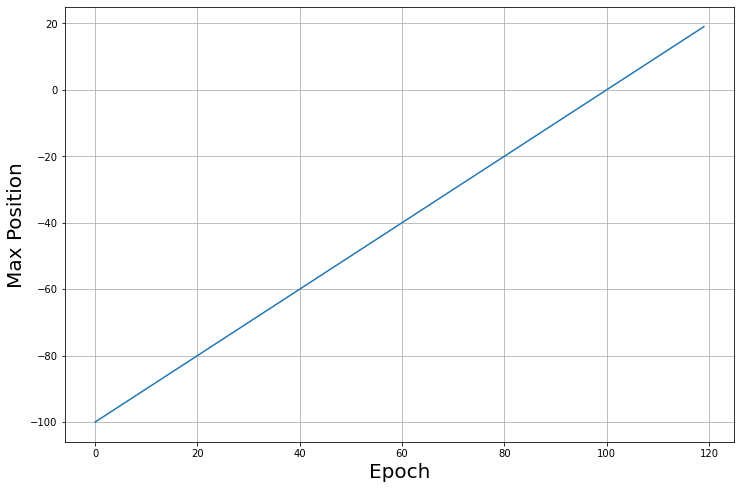

In [8]:
#Score plot - not reported in the report
plt.figure(figsize=(12,8))
plt.plot(score_log)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Max Position', fontsize=20)

plt.grid()
plt.savefig('score_plot_mountaincar_5_2000_4_maxpos')

plt.show()

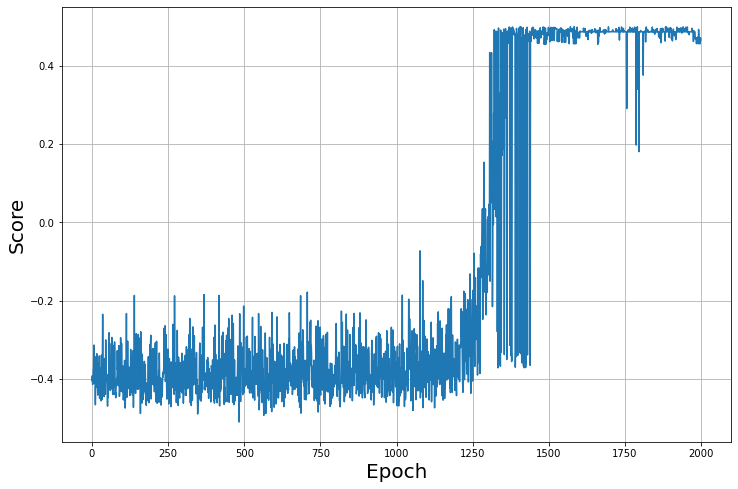

In [84]:
#Plot
plt.figure(figsize=(12,8))
plt.plot(max_pos_log)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Max Position', fontsize=20)

plt.grid()
plt.savefig('maxpos_plot_mountaincar_5_6000_4')

plt.show()

# Final test

In [87]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    max_pos = -1.2
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()

      if state[0]>max_pos:
        max_pos = state[0]
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {max_pos}") 
env.close()

EPISODE 1 - FINAL SCORE: 0.47164749483718305
EPISODE 2 - FINAL SCORE: 0.47164749483718305
EPISODE 3 - FINAL SCORE: 0.47164749483718305
EPISODE 4 - FINAL SCORE: 0.46212938993130237
EPISODE 5 - FINAL SCORE: 0.47164749483718305
EPISODE 6 - FINAL SCORE: 0.47164749483718305
EPISODE 7 - FINAL SCORE: 0.4883478613648016
EPISODE 8 - FINAL SCORE: 0.4883868875554273
EPISODE 9 - FINAL SCORE: 0.47164749483718305
EPISODE 10 - FINAL SCORE: 0.47164749483718305


In [86]:
# save to test
policy_net_state_dict = policy_net.state_dict()
# Save the state dict to a file
torch.save(policy_net_state_dict, 'policy_net_mountaincar_6_2000_4.torch')

target_net_state_dict = policy_net.state_dict()
# Save the state dict to a file
torch.save(target_net_state_dict, 'target_net_mountaincar_6_2000_4.torch')